# NEXT MONTH EXPENSE PREDICTION

In the following notebook we are adapting the baseline model in order to predict the next month expense on a given merchant type.

More for each user we calculate sum of expence in each merchant type to predict the expense in the next month taking into account all the previous monthes. 

We don't consider transactions with 'Снятие наличных' transaction type.

We adapt the baseline model for this Hackaton by using transformer model to encorporte the sequential structure of user's spendings. For this aim we use positional embeddings as an additional layer of embeddings. 

As a baseline for *our* task we took the very simple predictor - mean expence during privious monthes. In this work we investigate if there is a need in any complicated solution or our non-parametric baseline is also OK.

As a result we found that using the NN model we could slightly improve the quality of prediction, but honostly saying just taking the mean of expences during previous monthes is a very strong baseline. So we suggest a very simple but hard-to-beat solution to our next-month expence predictive model.

P.S. We suspect that some *other organizations*  also use such "average over past" predictor in their 
solution.

P.P.S. By other organithation we mean Sberbank actually.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install --upgrade numpy pandas tqdm torch catalyst==20.09

In [1]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

# GPU hack if you need
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
!unzip drive/My\ Drive/datasets/hackathon_data.zip
!mv hackathon_data drive/My\ Drive/datasets/

Archive:  drive/My Drive/datasets/hackathon_data.zip
replace hackathon_data/avk_hackathon_data_account_x_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: mv: inter-device move failed: 'hackathon_data' to 'drive/My Drive/datasets/hackathon_data'; unable to remove target: Directory not empty


# Data

Columns
- `party_rk` – client unique identifier
- `account_rk` – client account unique identifier
- `financial_account_type_cd` – debit/credit card flag
- `transaction_dttm` – operation datetime
- `transaction_type_desc` – purchase/payment/...
- `transaction_amt_rur` – transaction price
- `merchant_type` - DUTY FREE STORES/FUEL DEALERS/RESTAURANTS/ etc
- `merchant_group_rk` - McDonald's/Wildberries/ etc

It's important that table is already sorted by `transaction_dttm` column!!!

In [2]:
DATADIR = "/content/drive/My Drive/datasets/hackathon_data" # "./data"
transactions_path = f"{DATADIR}/avk_hackathon_data_transactions.csv"
pd.read_csv(f"{DATADIR}/avk_hackathon_data_transactions.csv", nrows=5)

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


Group our data by users and merchant types and compute total expence for each month.

In [ ]:
transactions = pd.read_csv(f"{DATADIR}/avk_hackathon_data_transactions.csv")

a = transactions.columns.values.tolist()
a.remove('transaction_dttm')
a.remove('transaction_amt_rur')

transactions['transaction_dttm'] = pd.to_datetime(transactions['transaction_dttm'])
tr_gb = transactions.groupby(['party_rk', 'merchant_type'])
df = tr_gb['account_rk'].count()
transactions = transactions.set_index(['party_rk', 'merchant_type']).loc[df[df > 10].index, :].reset_index()

transactions = transactions[transactions['transaction_type_desc'] != 'Снятие наличных']
a = ['party_rk', 'merchant_type']
tr_gb = transactions.groupby([pd.Grouper(key='transaction_dttm', freq='MS'),
                     *a])['transaction_amt_rur']
new_df = tr_gb.sum().reset_index()

# tr_gb = new_df.groupby(['party_rk', 'merchant_type'])
# df = tr_gb['transaction_amt_rur'].count()
# new_df = new_df.set_index(['party_rk', 'merchant_type']).loc[df[df >= 6].index, :].reset_index()

print(len(new_df.party_rk.unique()))
print(len(new_df.columns))
new_df.to_csv(f'{DATADIR}/new_transactions.csv')

## Mappings
~1 min

In [ ]:
# Prepare & save mappings
mappings = defaultdict(dict)
unk_token = "<UNK>"


def create_mapping(values):
    mapping = {unk_token: 0}
    for v in values:
        if not pd.isna(v):
            mapping[str(v)] = len(mapping)

    return mapping

for col in tqdm(
    [
        "transaction_type_desc",
        "merchant_rk",
        "merchant_type",
        "merchant_group_rk",
        "category",
        "financial_account_type_cd",
    ]
):
    col_values = (
        pd.read_csv(transactions_path, usecols=[col])[col]
        .fillna(unk_token)
        .astype(str)
    )
    mappings[col] = create_mapping(col_values.unique())
    del col_values


with open(f"{DATADIR}/mappings.json", "w") as f:
    json.dump(mappings, f)

In [4]:
#load mappings
with open(f"{DATADIR}/mappings.json", 'r') as f:
    mappings = json.load(f)

## Parse transactions by users
~ 15 min

In [5]:
pd_start_time = pd.to_datetime("2019-01-01")
pd_end_time = pd.to_datetime("2019-12-01")

In [ ]:
# Prepare & save client data
party2dates = defaultdict(list)  # for each party save a series of the transaction dates 
party2sum = defaultdict(list)  # for each party save a series of the transaction costs 
party2merchant_type = defaultdict(list)  # for each party save a series of the transaction_type 
party2trans_type = defaultdict(list)  # for each party save a series of the transaction merchant_type
party2days = defaultdict(list)

usecols = [
    "party_rk",
    "transaction_dttm",
    "transaction_amt_rur",
    "merchant_type",
]

for chunk in tqdm(
    pd.read_csv(f'{DATADIR}/new_transactions.csv', usecols=usecols, chunksize=100_000)
):

    chunk["transaction_dttm"] = (
        chunk["transaction_dttm"].fillna(unk_token).astype(str)
    )
    chunk["merchant_type"] = (
        chunk["merchant_type"].fillna(unk_token).astype(str)
    )

    chunk["transaction_amt_rur"] = chunk["transaction_amt_rur"].fillna(0)

    for i, row in chunk.iterrows():
        merchant_rk = mappings["merchant_type"][row.merchant_type]
        if (row.party_rk, merchant_rk) in party2dates.keys():
            months_zero_sum = (pd.to_datetime(row.transaction_dttm) - pd_start_time).days // 28 - len(party2dates[(row.party_rk, merchant_rk)]) 
        else:
            months_zero_sum = 0
        n = months_zero_sum
        sums = [0.0]*n + [row.transaction_amt_rur]
        party2dates[(row.party_rk, merchant_rk)].extend([row.transaction_dttm]*(n+1))
        party2sum[(row.party_rk, merchant_rk)].extend(sums)
        party2merchant_type[(row.party_rk, merchant_rk)].extend(
            [mappings["merchant_type"][row.merchant_type]]*(n+1)
        )
    
    del chunk

pickle.dump(party2dates, open(f"{DATADIR}/new_party2dates.pkl", "wb"))
pickle.dump(party2sum, open(f"{DATADIR}/new_party2sum.pkl", "wb"))
pickle.dump(party2merchant_type, open(f"{DATADIR}/new_party2merchant_type.pkl", "wb"))

In [6]:
# load client data
party2days = pickle.load(open(f"{DATADIR}/new_party2days.pkl", 'rb'))
party2dates = pickle.load(open(f"{DATADIR}/new_party2dates.pkl", 'rb'))
party2sum = pickle.load(open(f"{DATADIR}/new_party2sum.pkl", 'rb'))
party2merchant_type = pickle.load(open(f"{DATADIR}/new_party2merchant_type.pkl", 'rb'))

In [7]:
RUBBLE_DELIMETER = 10000

In [8]:
dates = pd.date_range("2019-01-01", "2019-12-01", freq="MS").strftime("%Y-%m-%d").tolist()

keys = list(party2dates.keys())
for key in keys:
    month_rest = 12 - len(party2sum[key])
    party2sum[key].extend(month_rest*[0.0])
    party2sum[key] = np.array(party2sum[key]) / RUBBLE_DELIMETER
    assert len(party2sum[key]) == 12, print(len(party2sum[key]))
    party2merchant_type[key].extend(party2merchant_type[-1]*month_rest)
    party2dates[key] = dates

In [9]:
from sklearn.model_selection import train_test_split

train_party, valid_party = train_test_split(
    pd.read_csv(f'{DATADIR}/new_transactions.csv', usecols=['party_rk']).party_rk.unique(), 
    train_size=0.8, random_state=42
)

print(f'Train: {len(train_party)} Val: {len(valid_party)}')

Train: 37997 Val: 9500


In [10]:
pairs = party2dates.keys()

user2merchants = defaultdict(list)
for party_rk, merchant_rk in pairs:
    user2merchants[party_rk].append(merchant_rk)

In [11]:
predict_period_len = 30  # -- days
train_predict_dates = (
    pd.date_range("2019-10-01", "2019-10-31", freq="MS") # predict only for fixed month for simplicity
    .strftime("%Y-%m-%d")
    .tolist()
)
valid_predict_dates = (
    pd.date_range("2019-11-01", "2019-12-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
submission_predict_dates = (
    pd.date_range("2020-01-01", "2020-02-28", freq="2MS")
    .strftime("%Y-%m-%d")
    .tolist()
)

In [12]:
def prepare_data(party_list, mode="train"):
    """
    This function define the pipeline of the creation of train and valid samples.
    We consider each client from party_list. For each client take each 
    predict_period_start from predict_dates list. All client transaction before
    this date is our features. Next, we look at the customer's transactions in 
    the next two months. This transactions should be predicted. It will form 
    our labels vector.
    """

    data_sum = []
    data_trans_type = []
    data_merchant_type = []
    data_labels = []
    pairs_list = []
    for party_rk in party_list:
        pairs_list.extend([(party_rk, m) for m in user2merchants[party_rk]])
    
    for (party_rk, merchant_rk) in tqdm(pairs_list):
        date_series = party2dates[(party_rk, merchant_rk)]
        sum_series = party2sum[(party_rk, merchant_rk)]
        merch_type_series = party2merchant_type[(party_rk, merchant_rk)]

        if mode == "train":
            predict_dates = train_predict_dates
        elif mode == "valid":
            predict_dates = valid_predict_dates
        elif mode == "submission":
            predict_dates = submission_predict_dates
        else:
            raise Exception("Unknown mode")

        for predict_period_start in predict_dates:

            predict_period_end = datetime.strftime(
                datetime.strptime(predict_period_start, "%Y-%m-%d")
                + timedelta(days=predict_period_len),
                "%Y-%m-%d",
            )

            l, r = (
                bisect_left(date_series, predict_period_start),
                bisect_right(date_series, predict_period_end),
            )

            if mode == 'train':
                r = 10
            elif mode == 'valid':
                r = 11

            merch_type_series = 12 * [merch_type_series[0]]
            history_merch_type = merch_type_series[:r]
            history_sum = sum_series[:r]
            predict_sum = sum_series[1:r+1]

            if len(sum_series) == 12 and np.sum([x > 0 for x in sum_series]) > 5:
                data_sum.append(history_sum)
                data_merchant_type.append(history_merch_type)
                data_labels.append(predict_sum)

            assert len(sum_series) == 12

    return data_sum, data_merchant_type, data_labels

In [13]:
train_sum, train_merchant_type, train_labels = prepare_data(
    train_party, mode="train"
)
valid_sum, valid_merchant_type, valid_labels = prepare_data(
    valid_party, mode="valid"
)

100%|██████████| 46369/46369 [00:03<00:00, 13963.49it/s]


Example of time series of monthly expences

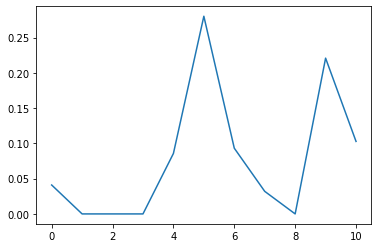

In [14]:
from matplotlib import pyplot as plt
import random

n = random.randint(0, len(train_sum))
last_del = list(train_labels[n][-1:])
plt.plot(np.arange(len(train_sum[n])+1), list(train_sum[n]) + last_del)

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

In [16]:
MERCH_TYPE_NCLASSES = len(mappings['merchant_type'])

In [17]:
class RSDataset(Dataset):
    def __init__(self, data_sum, data_merchant_type, labels):
        super(RSDataset, self).__init__()
        self.data_sum = data_sum
        self.data_merchant_type = data_merchant_type
        self.labels = labels

    def __len__(self):
        return len(self.data_sum)

    def __getitem__(self, idx):
        targets = np.array(self.labels[idx])

        item = {
            "features": {},
            "targets": targets,
        }

        sum_feature = np.array(self.data_sum[idx])
        item["features"]["sum"] = torch.from_numpy(sum_feature).float()

        for feature_name, feature_values in zip(
            ["merchant_type"],
            [self.data_merchant_type[idx]],
        ):

            feature_values = np.array(feature_values)
            feature_values = np.array(feature_values)
            mask = np.ones(feature_values.shape[0], dtype=np.float32)

            item["features"][feature_name] = torch.from_numpy(feature_values).long()
            item["features"][f"{feature_name}_mask"] = torch.from_numpy(mask).float()

        return item

In [18]:
train_dataset = RSDataset(
    train_sum, train_merchant_type, train_labels
)
valid_dataset = RSDataset(
    valid_sum, valid_merchant_type, valid_labels
)


In [19]:
train_loader = DataLoader(
    train_dataset, batch_size=1024, shuffle=True, num_workers=2
)
valid_loader = DataLoader(
    valid_dataset, batch_size=1024, shuffle=False, num_workers=2
)

In [20]:
train_batch = next(iter(train_loader))

In [21]:
# sanity check
# for i in tqdm(range(len(train_loader))):
#     batch = next(iter(train_loader))

## Model

In [22]:
import torch.nn as nn
from collections import OrderedDict

In [23]:
params = {
    'merchant_type_emb_dim': 127,
    'transformer_nhead': 2,
    'transformer_dim_feedforward': 128,
    'transformer_dropout': 0.1,
    'dense_unit': 128,
    'num_layers': 4,
}

In [24]:
MERCH_TYPE_NCLASSES#, TRANS_TYPE_NCLASSES

458

In [25]:
device = torch.device('cuda:0')

In [26]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=16):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[:x.size(1)].permute(1, 0, 2)
        x = x + pe
        return self.dropout(x)

class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [27]:
from torch.nn import functional as F

In [28]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.merchant_type_embedding = nn.Embedding(
            MERCH_TYPE_NCLASSES, params["merchant_type_emb_dim"]
        )
        embedding_size = (
            params["merchant_type_emb_dim"] + 1
            #+ 1
        )

        self.positional_embedding = PositionalEncoding(embedding_size)

        # self.transformer_blocks = []
        # for i in range(params["num_layers"]):
        #     transformer_block = nn.TransformerEncoderLayer(
        #         d_model=embedding_size,
        #         nhead=params["transformer_nhead"],
        #         dim_feedforward=params["transformer_dim_feedforward"],
        #         dropout=params["transformer_dropout"],
        #     )
        #     self.transformer_blocks.append(
        #         (f"transformer_block_{i}", transformer_block)
        #     )
        self.transformer_block1 = nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=params["transformer_nhead"],
                dim_feedforward=params["transformer_dim_feedforward"],
                dropout=params["transformer_dropout"],
            )
        self.transformer_block2 = nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=params["transformer_nhead"],
                dim_feedforward=params["transformer_dim_feedforward"],
                dropout=params["transformer_dropout"],
            )
        self.transformer_block3 = nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=params["transformer_nhead"],
                dim_feedforward=params["transformer_dim_feedforward"],
                dropout=params["transformer_dropout"],
            )
        self.transformer_block4 = nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=params["transformer_nhead"],
                dim_feedforward=params["transformer_dim_feedforward"],
                dropout=params["transformer_dropout"],
            )

        # self.transformer_encoder = nn.Sequential(
        #     OrderedDict(self.transformer_blocks)
        # )

        #self.transformer_encoder = OrderedDict(self.transformer_blocks)

        self.linear = nn.Linear(
            in_features=embedding_size, out_features=params["dense_unit"]
        )
        self.scorer = nn.Linear(
            in_features=params["dense_unit"],
            out_features=1,
        )

    def forward(self, features):
        mask = features["merchant_type_mask"]
        for k, v in features.items():
            features[k] = v.to(device)[:, :int(mask.sum(1)[0].item())]

        merchant_type_emb = self.merchant_type_embedding(features["merchant_type"].long())

        merchant_type_emb = merchant_type_emb * features["merchant_type_mask"].float().unsqueeze(-1)

        embeddings = torch.cat(
            (merchant_type_emb, features["sum"].float().unsqueeze(-1)),
            dim=-1,
        )
        embeddings = embeddings.permute(1, 0, 2)
        embeddings = self.positional_embedding(embeddings*100)

        src_mask = torch.ones(embeddings.shape[0], embeddings.shape[0]).to(device)
        for i in range(mask.shape[1]):
            for j in range(mask.shape[1]):
                if i == j - 1:
                    src_mask[i, j] = 0

        x = embeddings
        x = self.transformer_block1(src=x, src_mask=src_mask)
        x = self.transformer_block2(src=x, src_mask=src_mask)
        x = self.transformer_block3(src=x, src_mask=src_mask)
        x = self.transformer_block4(src=x, src_mask=src_mask)
        
        #transformer_output = self.transformer_encoder(embeddings, src_mask=src_mask)#[:, -1] # predict the next sum based on all seen
        #print(mask.sum(1).shape, transformer_output.shape)
        #transformer_output = transformer_output[np.arange(transformer_output.shape[0]), mask.sum(1).tolist(), :]
        #pooling = torch.mean(transformer_output, dim=1)
        linear = F.relu(self.linear(x))
        merch_logits = self.scorer(linear).permute(1, 0, 2).squeeze(-1)

        return merch_logits

### One-batch-check

In [29]:
model = Model()
model.to(device)
criterion = nn.L1Loss()
batch = next(iter(train_loader))
output = model(batch['features'])
loss = criterion(output, batch['targets'].float().to(device))
print(loss)

tensor(1.2115, device='cuda:0', grad_fn=<L1LossBackward>)


## Train loop with [Catalyst](https://github.com/catalyst-team/catalyst)

[A comprehensive step-by-step guide to basic and advanced features](https://github.com/catalyst-team/catalyst#step-by-step-guide).

---



In [31]:
from catalyst import dl, utils
from catalyst.utils import metrics

In [32]:
# What is Runner?
# https://catalyst-team.github.io/catalyst/api/core.html#runner
class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):
        # model train/valid step
        features, targets = batch["features"], batch["targets"]
        targets = targets.to(device)[:, 6:]
        logits = self.model(features)[:, 6:]

        loss = self.criterion(logits, targets.float())

        batch_metrics = {
            "loss": -loss,
            "abs_diff": -torch.abs(logits - targets).mean()*RUBBLE_DELIMETER,
            "relat_diff": -(torch.abs(logits - targets) / (targets + 1)).mean(),
        }
        
        self.input = {"features": features, "targets": targets}
        self.output = {"logits": logits}
        self.batch_metrics.update(batch_metrics)

        if self.is_train_loader:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10.0)
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    def predict_batch(self, batch):
        # model inference step
        batch = utils.maybe_recursive_call(batch, "to", device=self.device)
        logits = self.model(batch["features"])
        scores = logits
        return scores

In [33]:
model = Model()
model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

loaders = {"train": train_loader, "valid": valid_loader}

In [34]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs

In [35]:
tqdm._instances.clear()

In [36]:
# For other minimal examples, please follow the link below
# https://github.com/catalyst-team/catalyst#minimal-examples
runner = CustomRunner()
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    loaders=loaders,
    logdir="./logs",
    num_epochs=10,
    verbose=True,
    load_best_on_end=True,
    overfit=False,  #  <<<--- DO NOT FORGET TO MAKE IT ``False`` 
                    #  (``True`` uses only one batch to check pipeline correctness)

    main_metric="relat_diff", # "ap/mean", 
    minimize_metric=False,
)

1/10 * Epoch (train): 100% 127/127 [00:07<00:00, 17.47it/s, abs_diff=-9.871e+03, loss=-9.871e-01, relat_diff=-2.484e-01]
1/10 * Epoch (valid): 100% 64/64 [00:02<00:00, 23.12it/s, abs_diff=-1.094e+04, loss=-1.094e+00, relat_diff=-2.605e-01]
[2020-09-20 00:06:45,204] 
1/10 * Epoch 1 (train): abs_diff=-1.173e+04 | loss=-1.173e+00 | relat_diff=-2.525e-01
1/10 * Epoch 1 (valid): abs_diff=-1.120e+04 | loss=-1.120e+00 | relat_diff=-2.580e-01
2/10 * Epoch (train): 100% 127/127 [00:06<00:00, 18.93it/s, abs_diff=-8.085e+03, loss=-8.085e-01, relat_diff=-2.471e-01]
2/10 * Epoch (valid): 100% 64/64 [00:02<00:00, 22.95it/s, abs_diff=-1.019e+04, loss=-1.019e+00, relat_diff=-2.322e-01]
[2020-09-20 00:06:54,779] 
2/10 * Epoch 2 (train): abs_diff=-1.045e+04 | loss=-1.045e+00 | relat_diff=-2.433e-01
2/10 * Epoch 2 (valid): abs_diff=-1.045e+04 | loss=-1.045e+00 | relat_diff=-2.398e-01
3/10 * Epoch (train): 100% 127/127 [00:06<00:00, 18.82it/s, abs_diff=-8.755e+03, loss=-8.755e-01, relat_diff=-2.360e-01]
3

In [37]:
#!ls logs/checkpoints

In [38]:
#model.load_state_dict(torch.load('logs/checkpoints/best_full.pth'))

In [39]:
# R2 - R squared metric for computing explained variance (should be more than zero for a satisfying solution)

def compute_regression_metrics(model, dataloader):
    l1_loss = 0
    l2_loss = 0
    R2 = 0
    l2_loss_mean = 0
    
    with torch.no_grad():
      for batch in dataloader:
          prediction = model(batch['features'])[:, -1]
          target = batch['targets'].to(device)[:, -1]
          mean = batch['features']['sum'].mean(1)
          l1_loss += F.l1_loss(prediction, target)
          l2_loss += F.mse_loss(prediction, target)
          l2_loss_mean += F.mse_loss(mean, target)

    R2 = 1 - l2_loss / l2_loss_mean
    l2_loss = l2_loss / len(dataloader)
    l1_loss = l1_loss / len(dataloader)
    l2_loss_mean = l2_loss_mean / len(dataloader)

    return l1_loss, l2_loss, R2

l1_loss, l2_loss, R2 = compute_regression_metrics(model, valid_loader)
print(f'l1_loss {l1_loss}, l2_loss {l2_loss}, R2 {R2}')
  

l1_loss 1.2456588546380114, l2_loss 151.3647574189644, R2 -0.19792972103831974
